<a href="https://colab.research.google.com/github/sdhilip200/Content-Based-Recommendation---Good-Reads-data/blob/master/Recommendation_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kudzait/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Reading the data
df = pd.read_csv("data.csv")


# Text Preprocessing

In [4]:
#Utitlity functions for removing ASCII characters, converting lower case, removing stop words, html and punctuation from description

def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [5]:
df['Desc'] = df['Desc'].astype(str)

In [6]:
df['cleaned'] = df['Desc'].apply(_removeNonAscii)

df['cleaned'] = df.cleaned.apply(func = make_lower_case)
df['cleaned'] = df.cleaned.apply(func = remove_stop_words)
df['cleaned'] = df.cleaned.apply(func=remove_punctuation)
df['cleaned'] = df.cleaned.apply(func=remove_html)


# Building Average Word2Vec Model

In [7]:
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'
google_word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)


In [8]:
#splitting the description into words

i = 0
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

In [9]:
# Training our corpus with Google Pretrained Model
# %%time
google_model = Word2Vec(vector_size = 300, window=5, min_count = 2, workers = -1)
google_model.build_vocab(corpus)

In [10]:

google_model.wv.vectors_lockf = np.ones(len(google_model.wv))

In [11]:
type(google_model.wv)

gensim.models.keyedvectors.KeyedVectors

In [12]:
google_model.wv.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)

google_model.train(corpus, total_examples=google_model.corpus_count, epochs = 5)

(0, 0)

In [13]:
google_model.wv.most_similar(positive=["steve"])

[('dave', 0.7480319738388062),
 ('jeff', 0.6910731196403503),
 ('jason', 0.6878509521484375),
 ('robert', 0.6830392479896545),
 ('george', 0.6792418360710144),
 ('kevin', 0.6762767434120178),
 ('todd', 0.6758198738098145),
 ('jeremy', 0.6757494211196899),
 ('ryan', 0.6735630035400391),
 ('greg', 0.6706034541130066)]

In [14]:
google_model.wv.most_similar(positive=["symbol"])

[('symbols', 0.7067205309867859),
 ('symbolize', 0.559971034526825),
 ('embodiment', 0.46211811900138855),
 ('icon', 0.46183207631111145),
 ('beacon', 0.44511622190475464),
 ('logo', 0.4354955852031708),
 ('emblematic', 0.40704354643821716),
 ('symbolic', 0.40256598591804504),
 ('metaphor', 0.39921829104423523),
 ('touchstone', 0.3798491656780243)]

In [15]:
# Generate the average word2vec for the each book description

def vectors(x):
    
    # Creating a list for storing the vectors (description into vectors)
    global word_embeddings
    word_embeddings = []

    # Reading the each book description 
    for line in df['cleaned']:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in list(google_model.wv.index_to_key):
                count += 1
                if avgword2vec is None:
                    avgword2vec = google_model.wv[word]
                else:
                    avgword2vec = avgword2vec + google_model.wv[word]
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
        
            word_embeddings.append(avgword2vec)


In [16]:
# Recommending the Top 5 similar books

def recommendations(title):
    
    # Calling the function vectors

    vectors(df)
    
    # finding cosine similarity for the vectors

    cosine_similarities = cosine_similarity(word_embeddings, word_embeddings)

    # taking the title and book image link and store in new data frame called books
    books = df[['title', 'image_link']]
    #Reverse mapping of the index
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()
         
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    book_indices = [i[0] for i in sim_scores]
    recommend = books.iloc[book_indices]
    for index, row in recommend.iterrows():

        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        plt.title(row['title'])

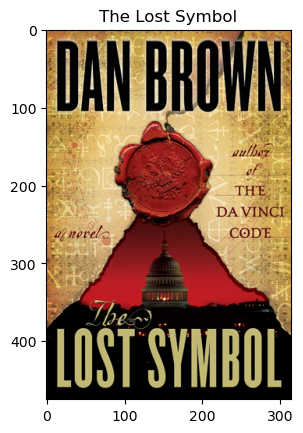

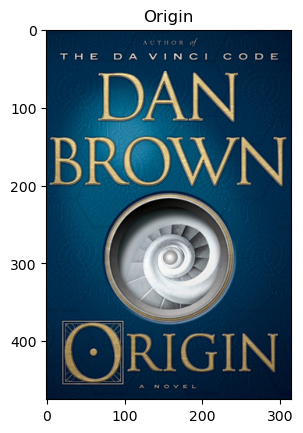

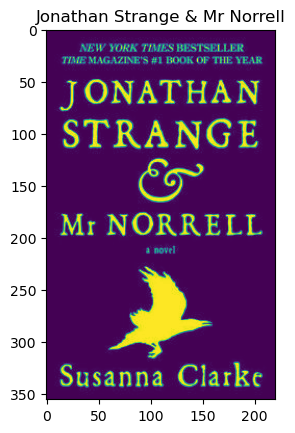

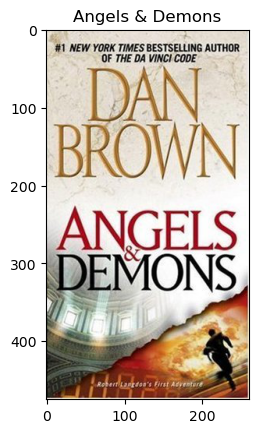

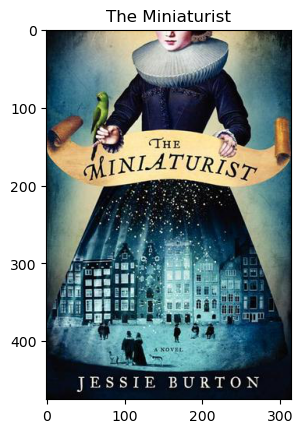

In [17]:
recommendations("The Da Vinci Code")

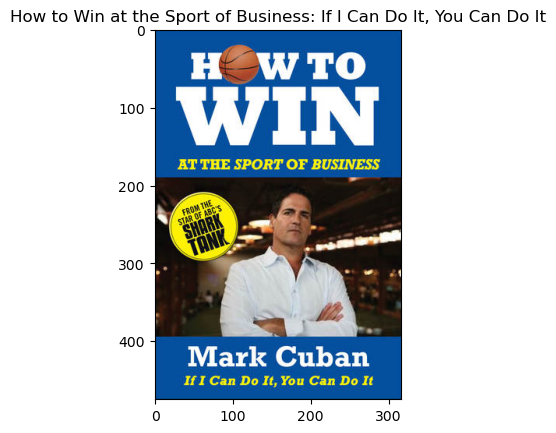

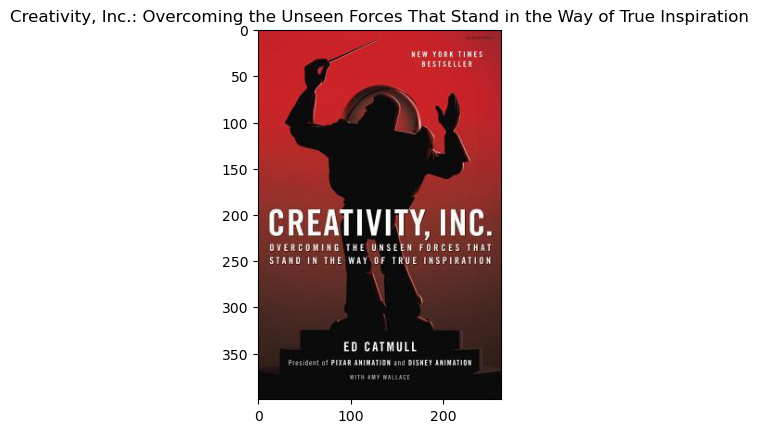

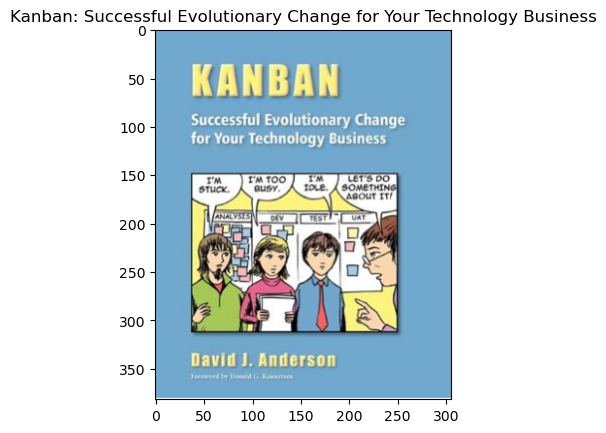

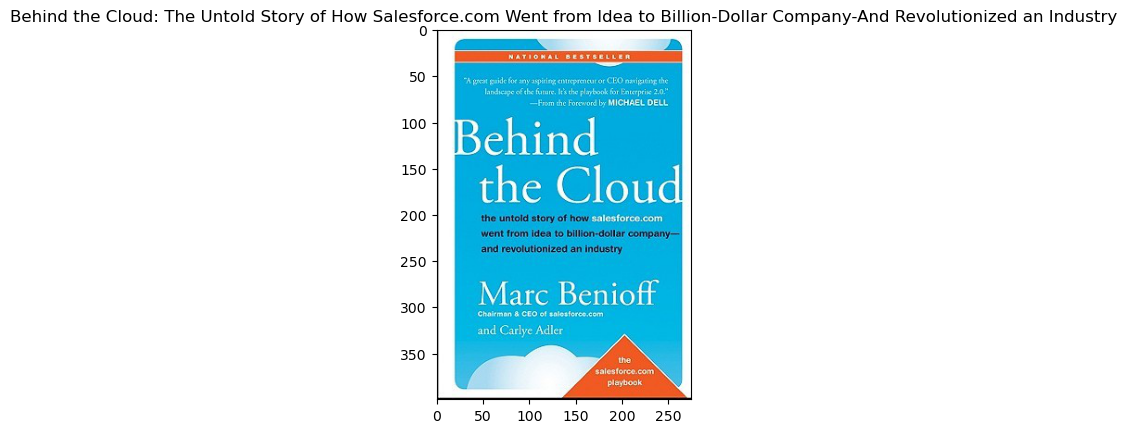

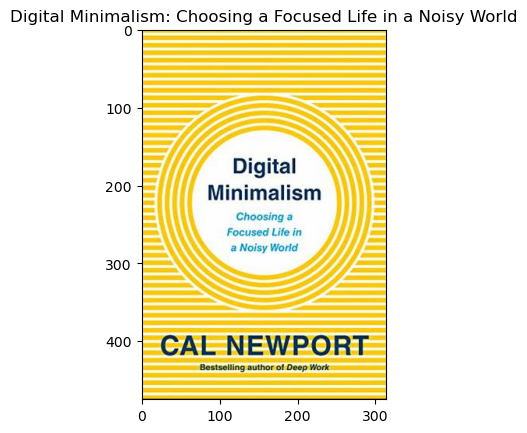

In [18]:
recommendations("Steve Jobs")

# Building TF-IDF Word2Vec Model

In [19]:
#Building TFIDF model and calculate TFIDF score

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df = 5, stop_words='english')
tfidf.fit(df['cleaned'])

# Getting the words from the TF-IDF model

tfidf_list = dict(zip(tfidf.get_feature_names_out(), list(tfidf.idf_)))
tfidf_feature = tfidf.get_feature_names_out() # tfidf words/col-names

In [20]:
# Building TF-IDF Word2Vec 

# Storing the TFIDF Word2Vec embeddings
tfidf_vectors = []; 
line = 0;
# for each book description
for desc in corpus: 
  # Word vectors are of zero length (Used 300 dimensions)
    sent_vec = np.zeros(300) 
    # num of words with a valid vector in the book description
    weight_sum =0; 
    # for each word in the book description
    for word in desc: 
        if word in list(google_model.wv.index_to_key) and word in tfidf_feature:
            vec = google_model.wv[word]
            tf_idf = tfidf_list[word] * (desc.count(word) / len(desc))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors.append(sent_vec)
    line += 1

In [21]:
#Recommending top 5 similar books

def recommendations(title):
    
    # finding cosine similarity for the vectors

    cosine_similarities = cosine_similarity(tfidf_vectors,  tfidf_vectors)
    
    # taking the title and book image link and store in new data frame called books
    books = df[['title', 'image_link']]
    #Reverse mapping of the index
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()
         
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    book_indices = [i[0] for i in sim_scores]
    recommend = books.iloc[book_indices]
    for index, row in recommend.iterrows():

        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        plt.title(row['title'])

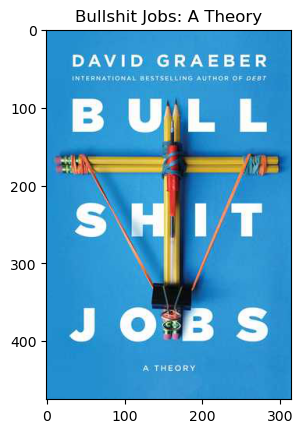

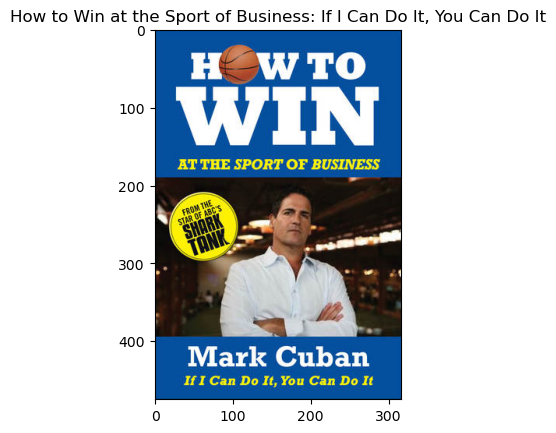

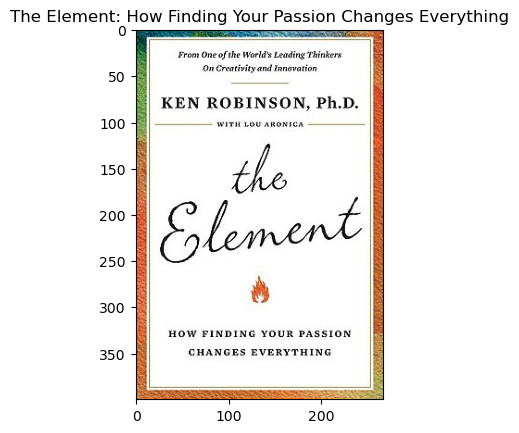

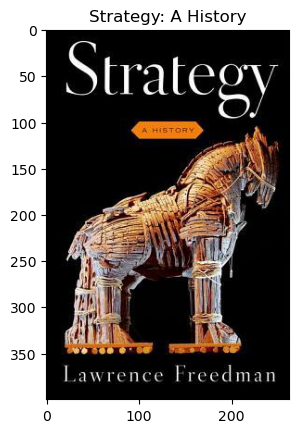

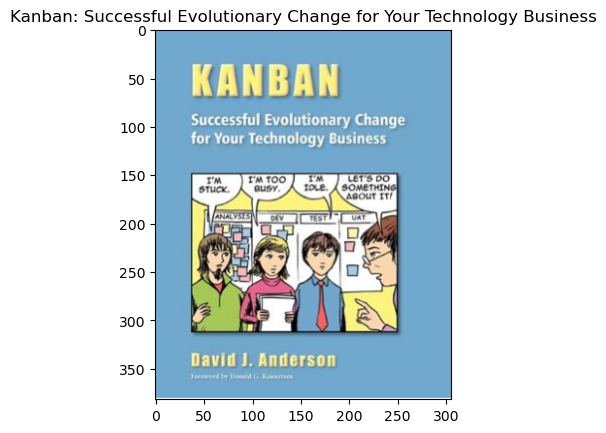

In [22]:
recommendations("Steve Jobs")

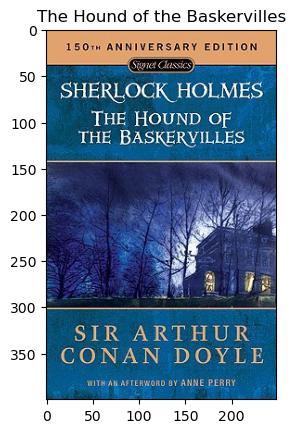

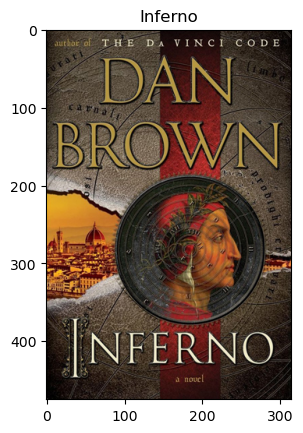

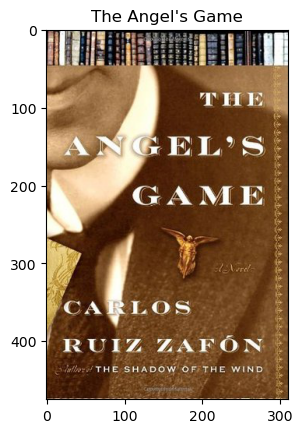

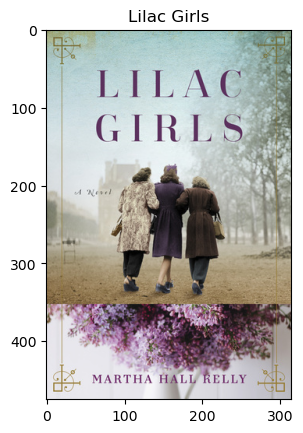

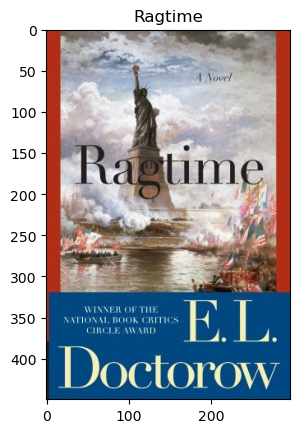

In [35]:
recommendations("The Da Vinci Code")

In [23]:
google_model.save('models/books.npz')

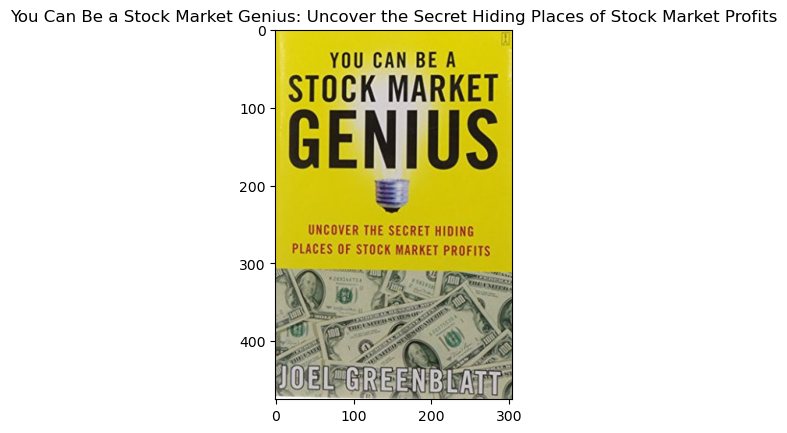

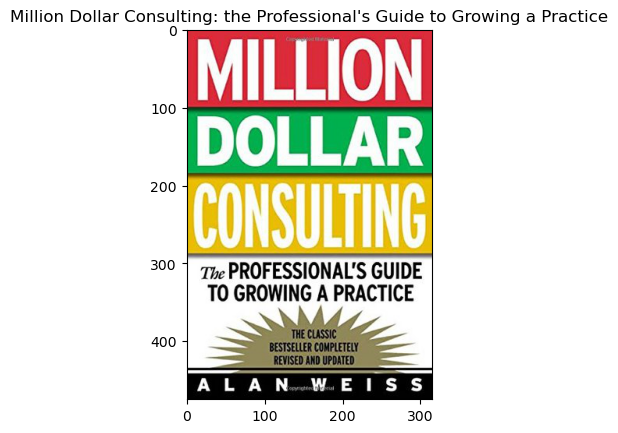

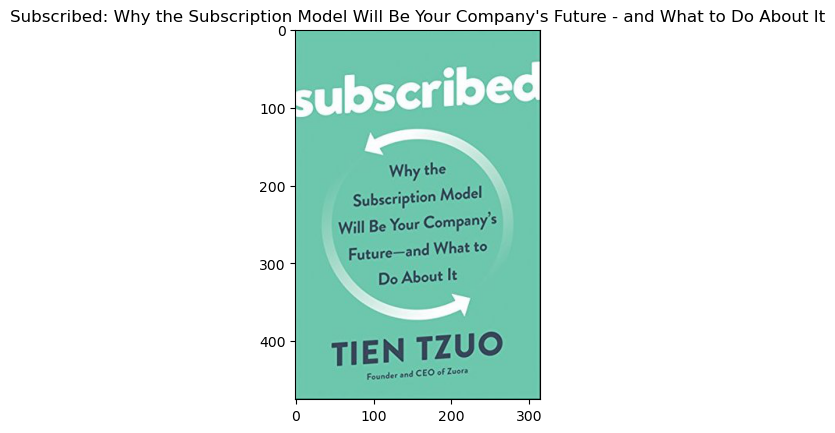

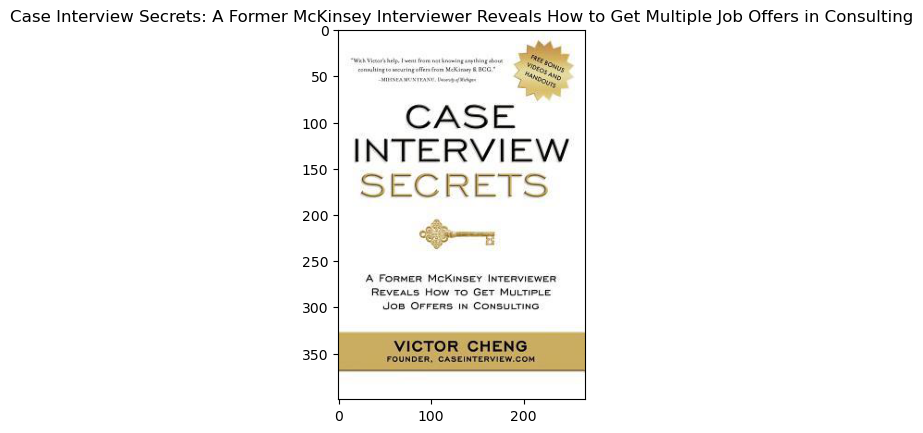

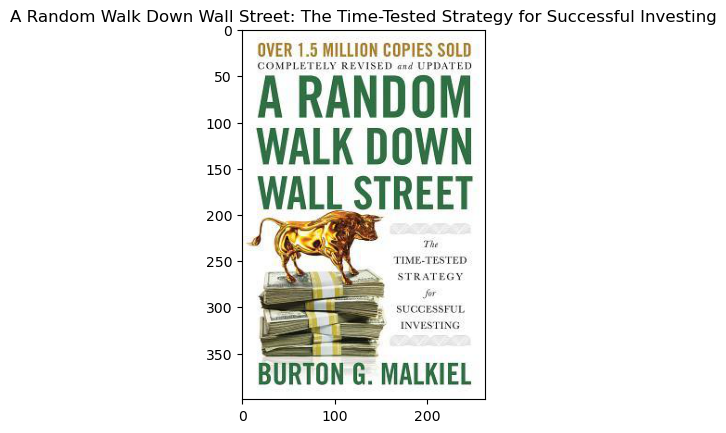

In [26]:
recommendations('The Four Pillars of Investing')

In [37]:
new_model = Word2Vec.load('book_recommender_wv_model')

In [38]:
df.to_csv('dataset.csv')

In [29]:
df['title'].str.contains('Shoe Dog').any()

True

In [27]:
df.head()

Unnamed: 0.1                                               Desc  \
0             0  We know that power is shifting: From West to E...   
1             1  Following the success of The Accidental Billio...   
2             2  How to tap the power of social software and ne...   
3             3  William J. Bernstein is an American financial ...   
4             4  Amazing book. And I joined Steve Jobs and many...   

   Unnamed: 0                author     genre  \
0         0.0           Moisés Naím  Business   
1         1.0       Blake J. Harris  Business   
2         2.0          Chris Brogan  Business   
3         3.0  William J. Bernstein  Business   
4         4.0           Akio Morita  Business   

                                          image_link  rating  \
0  https://i.gr-assets.com/images/S/compressed.ph...    3.63   
1  https://i.gr-assets.com/images/S/compressed.ph...    3.94   
2  https://i.gr-assets.com/images/S/compressed.ph...    3.78   
3  https://i.gr-assets.com/images/S/compressed.ph...    4.20   
4  https://i.gr-assets.com/images/S/compressed.ph...    4.05   

                                               title  \
0  The End of Power: From Boardrooms to Battlefie...   
1  Console Wars: Sega, Nintendo, and the Battle t...   
2  Trust Agents: Using the Web to Build Influence...   
3                      The Four Pillars of Investing   
4                Made in Japan: Akio Morita and Sony   

                                             cleaned  
0  know power shifting west east north south pres...  
1  following success accidental billionaires mone...  
2  tap power social software networks build busin...  
3  william j bernstein american financial theoris...  
4  amazing book joined steve jobs many akio morit...

In [31]:
df.dtypes

Unnamed: 0.1      int64
Desc             object
Unnamed: 0      float64
author           object
genre            object
image_link       object
rating          float64
title            object
cleaned          object
dtype: object